In [3]:
import numpy as np
from numpy import genfromtxt

import csv
import os

import deepSI
from deepSI import System_data

import pysindy as ps
from pysindy import SINDy

from torch import nn
import torch

import matplotlib.pyplot as plt

from scipy.io import loadmat

from deepSI.utils import simple_res_net, feed_forward_nn

from utils import SINDy_model

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
# data dir and file
save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"

out = loadmat(os.path.join(save_dir,'Silverbox_full_state_low_error.mat'))
x_data = out['xOptTot']

save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"
out = loadmat(os.path.join(save_dir,'Silverbox_u_upsampled.mat'))
u = out['u']

save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data"
out = loadmat(os.path.join(save_dir,'Maarten_coeff.mat'))
true_coeff = out['thOpt'][0]

# store in deepsi data object
train, test = System_data(u=u[800000:],y=x_data[800000:]), System_data(u=u[:800000],y=x_data[:800000])

In [104]:
# custom class with basic SINDy implementation
dt = 1
threshold=1e-6

feature_library=ps.PolynomialLibrary(degree=3,include_interaction=False)

model = SINDy_model(
  x_data=train.y,
  u_data=train.u,
  x_test=test.y, # if not specified will use data_split to create test set
  u_test=test.u,
  data_split=None, # percentage of x_data/u_data that will be used for testing
  discrete_time=True,
  t_default=dt,
  optimizer=ps.STLSQ(threshold=1e-8),
  feature_library=feature_library
)

model.fit_s()
model.print(precision=6)
predicted = model.predict_s()
# simulated = model.simulate_s()

(x0)[k+1] = 1.000000 x0[k] + 1.000000 x1[k]
(x1)[k+1] = -0.000009 1 + -0.001240 x0[k] + 0.995270 x1[k] + 0.001251 u0[k] + -0.004751 x0[k]^3


In [6]:
coeff = model.coefficients()

for idx_i, i in enumerate(coeff):
  for idx_j, j in enumerate(i):
    if np.abs(j)<threshold:
      coeff[idx_i,idx_j] = 0

In [135]:
import sympy

true_coeff_r = [round(i,7) for i in true_coeff]

k1 = true_coeff_r[0]
k3 = true_coeff_r[1]
c = true_coeff_r[2]
d = true_coeff_r[3]
yOffset = true_coeff_r[4]
uOffset = true_coeff_r[5]

x1 = sympy.Symbol('x_{0}[k]')
x2 = sympy.Symbol('x_{1}[k]')
x1_1 = sympy.Symbol('x_{0}[k+1]')
x2_1 = sympy.Symbol('x_{1}[k+1]')
u = sympy.Symbol('u[k]')

x1_eq = sympy.Eq(x1_1, x1+x2+ yOffset)
x2_eq = sympy.Eq(x2_1, x2-k1*x1 -k3*(x1**3) -c*x2 + d*(u-uOffset))

x1_true = np.array([yOffset, 1, 1])
x2_true = np.array([d*uOffset, k1, 1-c, d, k3])

In [102]:
x1_eq

Eq(x_{0}[k+1], x_{0}[k] + x_{1}[k] + 0.0019565)

In [103]:
x2_eq

Eq(x_{1}[k+1], 0.0012511*u[k] - 0.0047515*x_{0}[k]**3 - 0.0012399*x_{0}[k] + 0.9952699*x_{1}[k] - 9.18982994e-6)

In [126]:
model.print(precision=6)

(x0)[k+1] = 1.000000 x0[k] + 1.000000 x1[k]
(x1)[k+1] = -0.000009 1 + -0.001240 x0[k] + 0.995270 x1[k] + 0.001251 u0[k] + -0.004751 x0[k]^3


In [136]:
np.abs(coeff[1,coeff[1,:] !=0 ]), np.abs(x2_true)

(array([9.18958675e-06, 1.23985502e-03, 9.95269866e-01, 1.25106467e-03,
        4.75149738e-03]),
 array([9.18982994e-06, 1.23990000e-03, 9.95269900e-01, 1.25110000e-03,
        4.75150000e-03]))

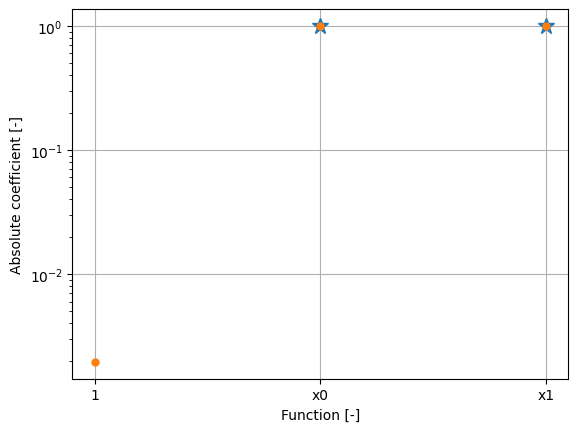

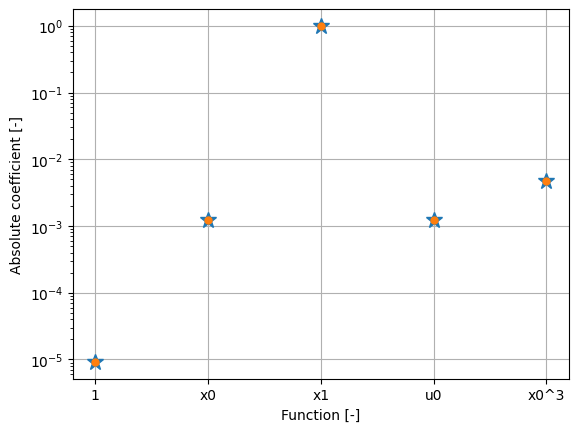

In [172]:
plt.semilogy([1,2],np.abs(coeff[0,coeff[0,:] !=0 ]),"*", markersize=12)
plt.semilogy(np.abs(x1_true),"o", markersize=5)
plt.xticks(np.arange(x1_true.shape[0]), ['1','x0','x1'])
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.grid()
plt.show()

plt.semilogy(np.abs(coeff[1,coeff[1,:] !=0 ]),"*", markersize=12)
plt.semilogy(np.abs(x2_true),"o", markersize=5)
plt.xticks(np.arange(x2_true.shape[0]), ['1','x0','x1','u0','x0^3'])
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.grid()
plt.show()